In [1]:
import sys
sys.path.append("../../../..")
%load_ext autoreload
%autoreload 1
import lightning.pytorch as pl
from lightning.pytorch.callbacks import DeviceStatsMonitor
from lightning.pytorch.tuner.tuning import Tuner
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
plt.style.use(hep.style.CMS)

from ntupleReaders.clue_ntuple_reader import ClueNtupleReader

from ml.dynamic_reduction_network import DynamicReductionNetwork
%aimport ml.regression.drn.modules
%aimport ml.regression.drn.dataset_making
from ml.regression.drn.modules import *
from ml.regression.drn.dataset_making import *

%aimport ml.regression.drn.callbacks.sigma_over_e
from ml.regression.drn.callbacks.sigma_over_e import SigmaOverEPlotter, makeHist
%aimport energy_resolution.sigma_over_e
from energy_resolution.sigma_over_e import SigmaOverEComputations, SigmaOverEPlotElement, plotSigmaOverMean
%matplotlib inline

2023-07-07 13:47:08.262692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 13:47:08.408745: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
reader = ClueNtupleReader("v41", "cmssw", "data")
datamodule = DRNDataModule(reader, datasetComputationClass=RechitsTensorMaker,#LayerClustersTensorMaker, 
                           multiprocess_loader=True, batch_size=2048)
model = DRNModule(drn=DynamicReductionNetwork(input_dim=4,hidden_dim=50,k=5,output_dim=1,
                    norm=torch.tensor([0.07352941176470588, 0.07352941176470588, 0.03571428571428571, 50.0])),
        loss=RatioCorrectedLoss(
            #[-0.28349774, -0.2556718, 1.0477022] # sim
            [-0.2597882, -0.24326517, 1.01537901] # data
            ), optimizer=None)
devices = [2]

In [3]:
trainer = pl.Trainer(accelerator="gpu", devices=devices, enable_progress_bar=True, fast_dev_run=False, logger=False,
             max_epochs=3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
res = trainer.predict(model=model, datamodule=datamodule, 
    ckpt_path="/grid_mnt/data_cms_upgrade/cuisset/testbeam18/ml/regression-runs/Jul01-rechits-data/lightning_logs/dropout=0.3-hidden_dim=50-k=5-lr_scheduler=50/checkpoints/epoch=269-step=42660.ckpt"
    #"/grid_mnt/data_cms_upgrade/cuisset/testbeam18/ml/regression-runs/Jul01-LC-data/lightning_logs/dropout=0.05-hidden_dim=100-k=10/checkpoints/epoch=169-step=13430.ckpt"
)

Restoring states from the checkpoint path at /grid_mnt/data_cms_upgrade/cuisset/testbeam18/ml/regression-runs/Jul01-rechits-data/lightning_logs/dropout=0.3-hidden_dim=50-k=5-lr_scheduler=50/checkpoints/epoch=269-step=42660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /grid_mnt/data_cms_upgrade/cuisset/testbeam18/ml/regression-runs/Jul01-rechits-data/lightning_logs/dropout=0.3-hidden_dim=50-k=5-lr_scheduler=50/checkpoints/epoch=269-step=42660.ckpt
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


In [5]:
plotter = SigmaOverEPlotter(fit_data="full",  overlaySigmaOverEResults=[reader.loadSigmaOverEResults("rechits"), reader.loadSigmaOverEResults("clue3d")],
                            beamEnergiesInTestSet=datamodule.dataset_test.beamEnergiesToSelect)
plotter.fillHistogramFromPrediction(res, datamodule.predict_dataloader(), model.loss_params)
plotter.sigma_mu_fits()
plotter.fitSigmaOverE()

/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


EResolutionFitResult(S=0.2219555313780745+/-0.0013216327723631802, C=0.003569047813409048+/-0.0007113241667044541)

In [6]:
from hists.store import HistogramId
from HistogramLib.histogram import HistogramKind

def makeRawHist() -> hist.Hist:
    h, h_corr = makeHist(), makeHist()
    for batch in datamodule.predict_dataloader():
        h.fill(batch.beamEnergy.numpy(), batch.tracksterEnergy.numpy())
        correctedEstimate  = model.loss_params.simpleCorrectedEnergyEstimate(batch)
        h_corr.fill(batch.beamEnergy.numpy(), correctedEstimate.numpy())
    return h, h_corr
raw_h, raw_corrected_h = makeRawHist()

plotter_reference = SigmaOverEPlotter(fit_data="full",  overlaySigmaOverEResults=[reader.loadSigmaOverEResults("rechits"), reader.loadSigmaOverEResults("clue3d")])
plotter_reference.histogram_2D = raw_corrected_h
plotter_reference.sigma_mu_fits()
plotter_reference.fitSigmaOverE()

/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


EResolutionFitResult(S=0.22741392366792984+/-0.0013900247737953647, C=0.004181689318749838+/-0.0006404962285515082)

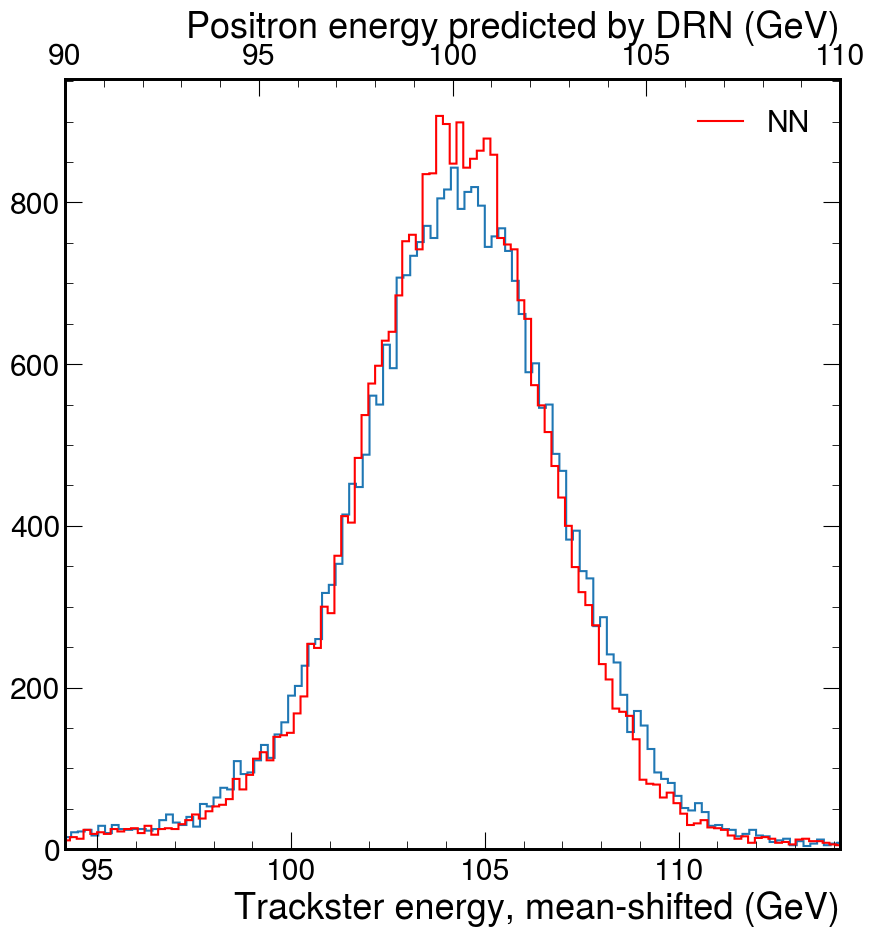

In [12]:
def getMPVLocation(h:hist.Hist):
    """ Get center of bin of most probable value """
    return h.axes[0].centers[np.argmax(h.counts())]

def getHistAvg(h:hist.Hist):
    return np.average(h.axes[0].centers, weights=h.view())

def computeEnergyShift(h_model, h_toScale):
    mpv_model = getHistAvg(h_model)
    mpv_toScale = getHistAvg(h_toScale)
    return  mpv_toScale - mpv_model

def plotCompForEnergy(beamEnergy, rebin=2, xLim=None):
    h_pred = plotter.histogram_2D[hist.loc(beamEnergy), :]
    # rawTracksterEnergy_h = (
    #     reader.histStore.get(HistogramId("Clus3DClusteredEnergy", "cmssw", reader.datatype))
    #     .getHistogram(HistogramKind.COUNT)
    #     [{"beamEnergy":hist.loc(beamEnergy), "mainOrAllTracksters":hist.loc("mainTrackster")}]
    #     .project("clus3D_energy")
    # )

    fig, axRaw = plt.subplots()
    #axRaw.yaxis.set_ticks_position('left')

    mplhep_kwargs = dict(yerr=False)
    hep.histplot(raw_corrected_h[{"beamEnergy":hist.loc(beamEnergy)}][::hist.rebin(rebin)], label="Raw", ax=axRaw, **mplhep_kwargs)

    #axIntermediate = axRaw.twiny()
    axNN = axRaw.twiny()
    # need to use this intermediate axis otherwise xlabel at top does not work
    axNN.set_xlabel("Positron energy predicted by DRN (GeV)")
    

    #hep.histplot(h_pred)
    hep.histplot(h_pred[::hist.rebin(rebin)], label="NN", ax=axNN, color="red", **mplhep_kwargs)
    #plt.xlim(beamEnergy*0.7, beamEnergy*1.1)

    axRaw.set_xlabel("Trackster energy, mean-shifted (GeV)")
    #axNN.set_xlabel("")

    if not xLim:
        xLim = 0.9*beamEnergy,1.1*beamEnergy
    axNN.set_xlim(xLim)
    shift = computeEnergyShift(h_pred, raw_corrected_h[{"beamEnergy":hist.loc(beamEnergy)}])
    #shift=0
    axRaw.set_xlim(xLim[0]+shift, xLim[1]+shift)

    plt.legend()
    
plotCompForEnergy(100, rebin=1)

[30, 100, 250]

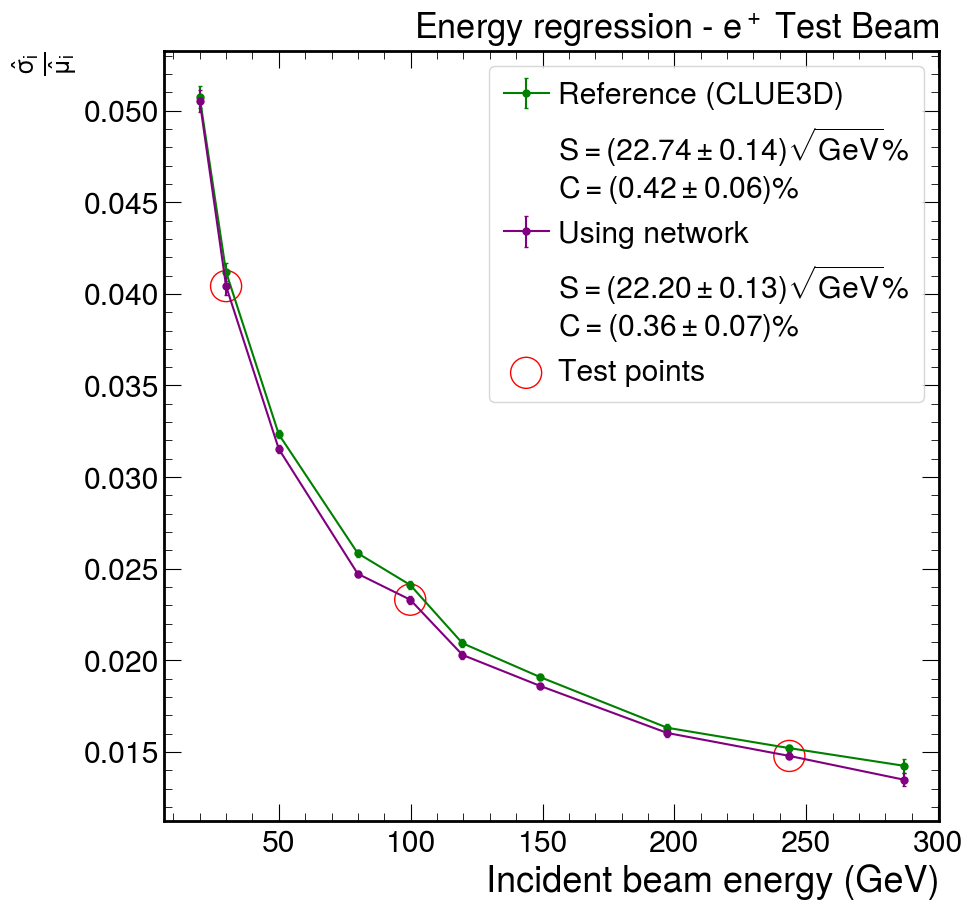

In [10]:
import dataclasses
reference_plotElt = dataclasses.replace(plotter_reference.plotElt, legend = "Reference (CLUE3D)", color="green")
ML_plotElt = dataclasses.replace(plotter.plotElt, legend = "Using network", beamEnergiesInTestSet=datamodule.dataset_test.beamEnergiesToSelect)
plotter.overlaySigmaOverEResults = [reference_plotElt]
plotter.plotSigmaOverMean(plotElements=[reference_plotElt, ML_plotElt], legend=False, lumitext="Energy regression - $e^+$ Test Beam")
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 0, 4, 1, 2]
plt.legend(handles=[handles[idx] for idx in order], frameon=True, handletextpad=0.3)
plt.savefig("../plots-results/rechits-data-h=50-k=5.pdf", bbox_inches="tight")

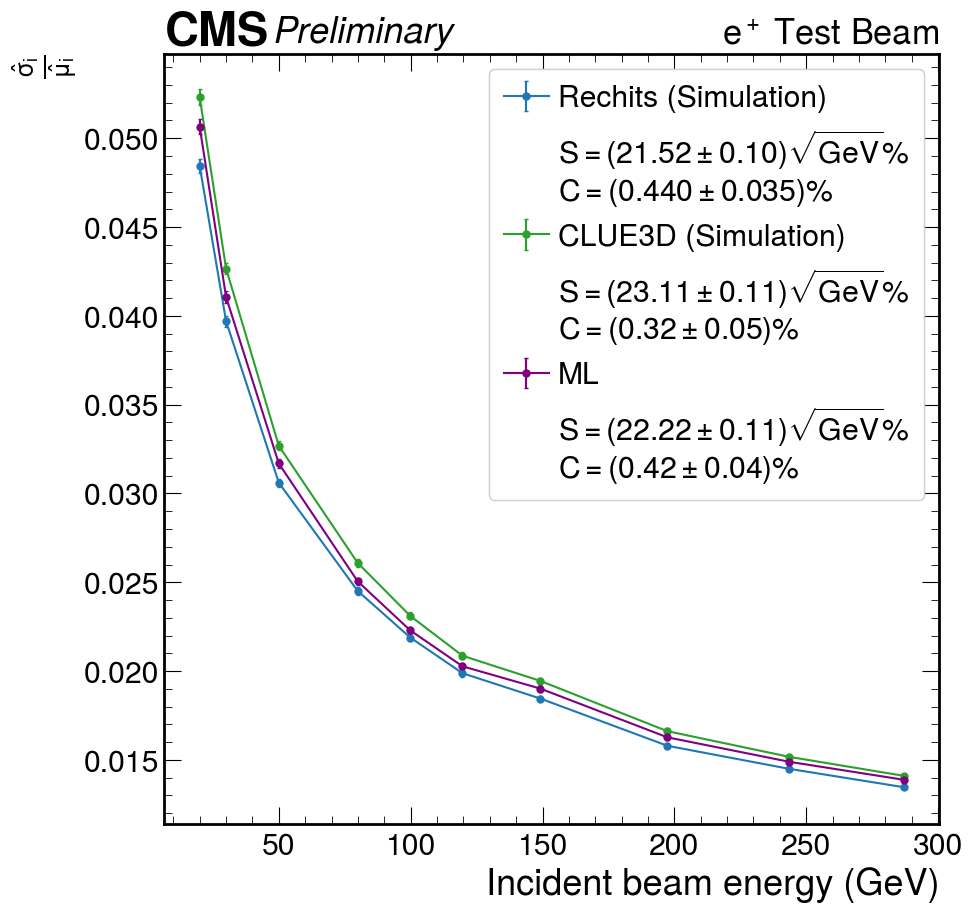

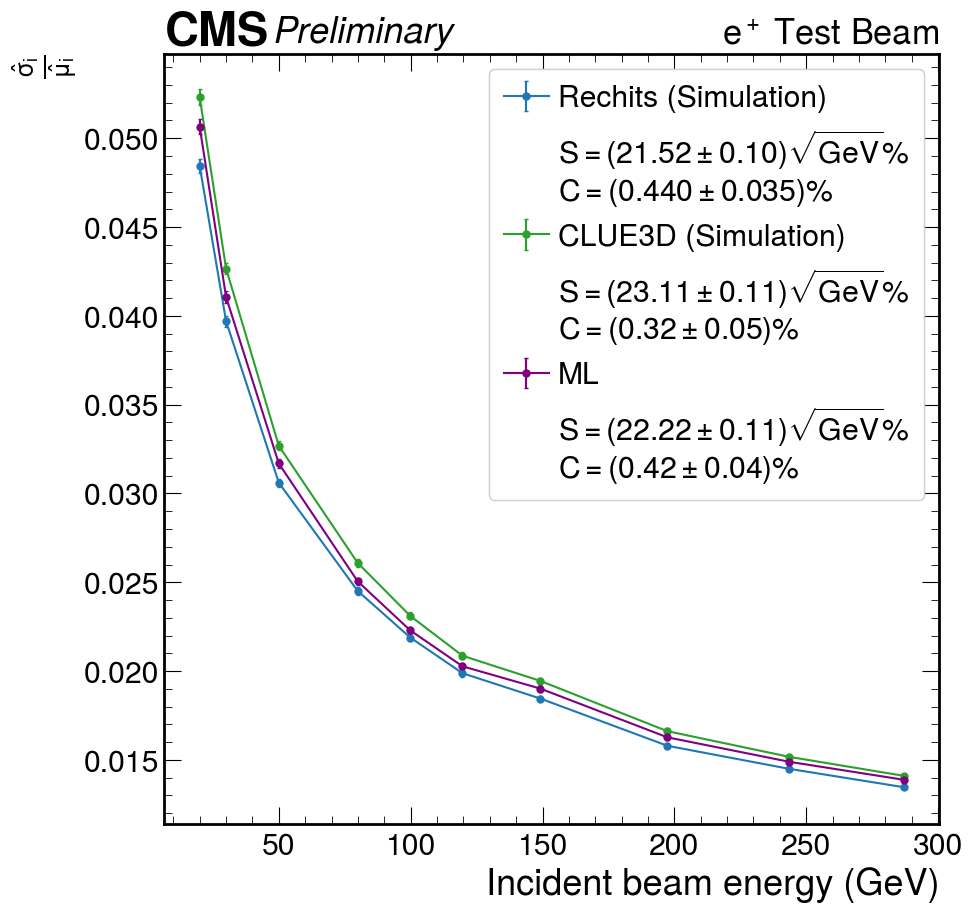

In [45]:
plotter.plotSigmaOverMean()
None

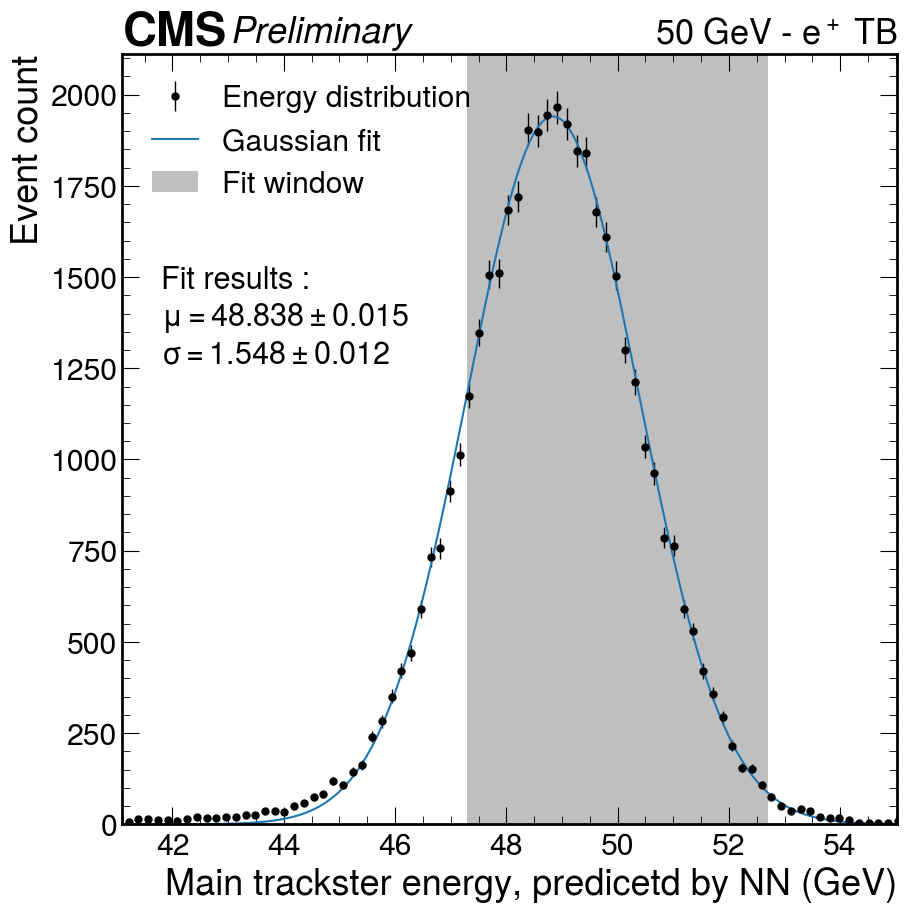

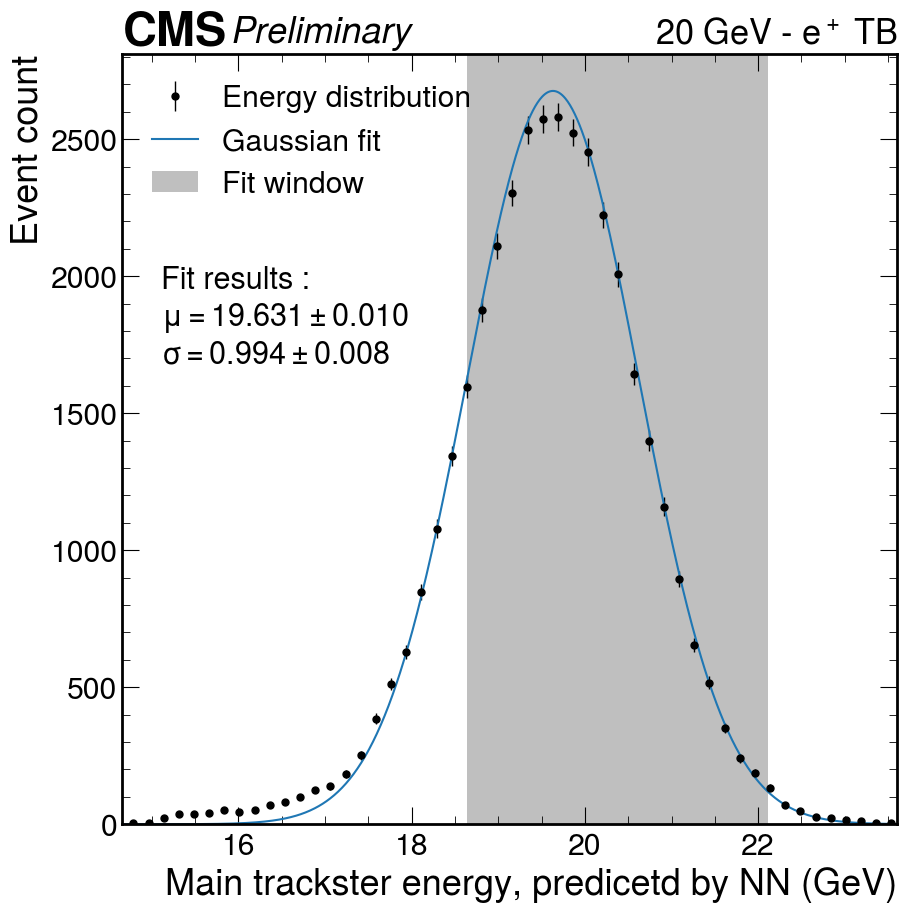

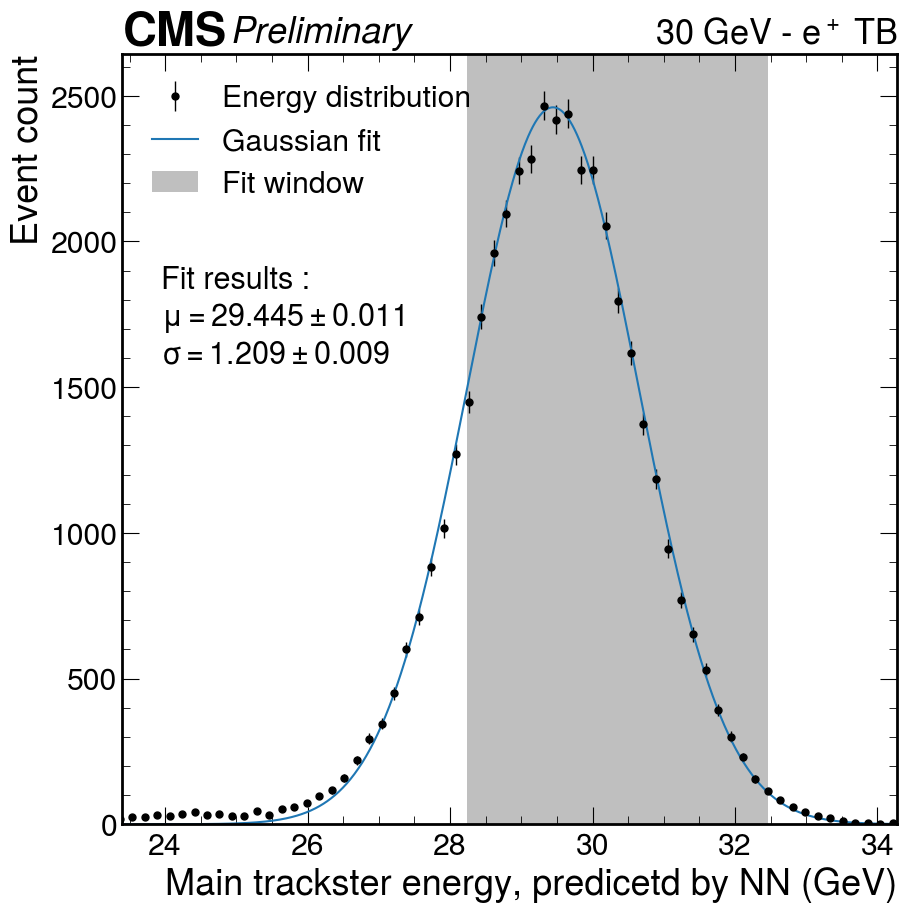

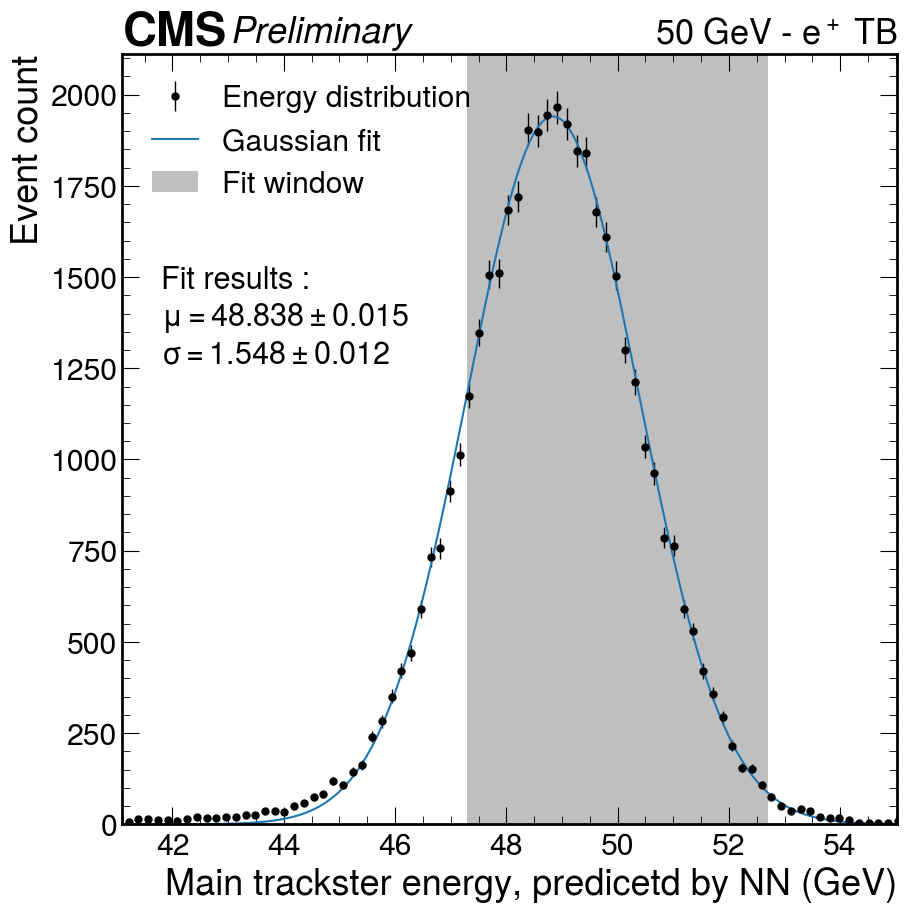

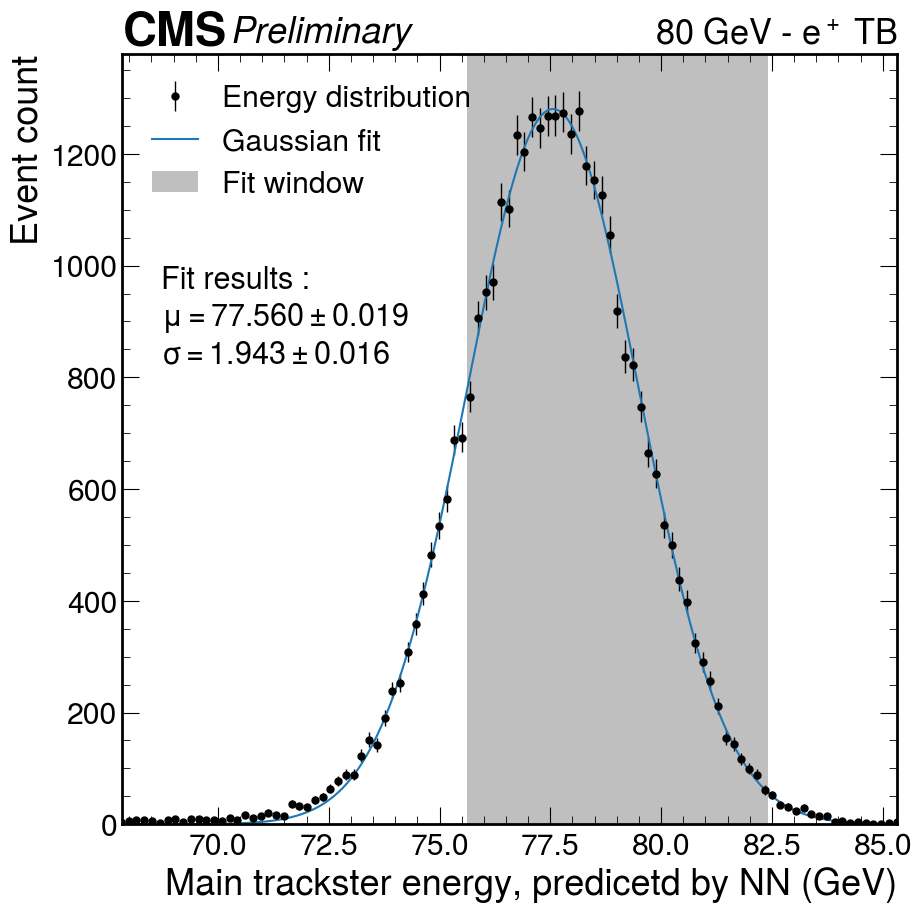

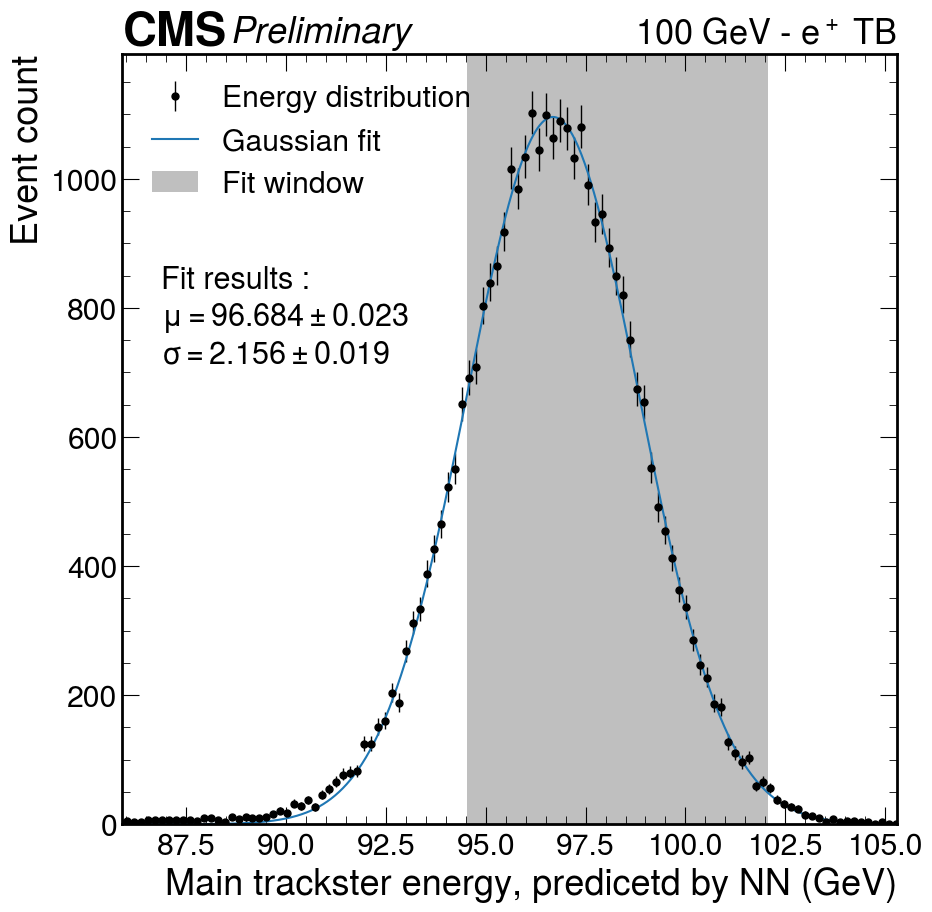

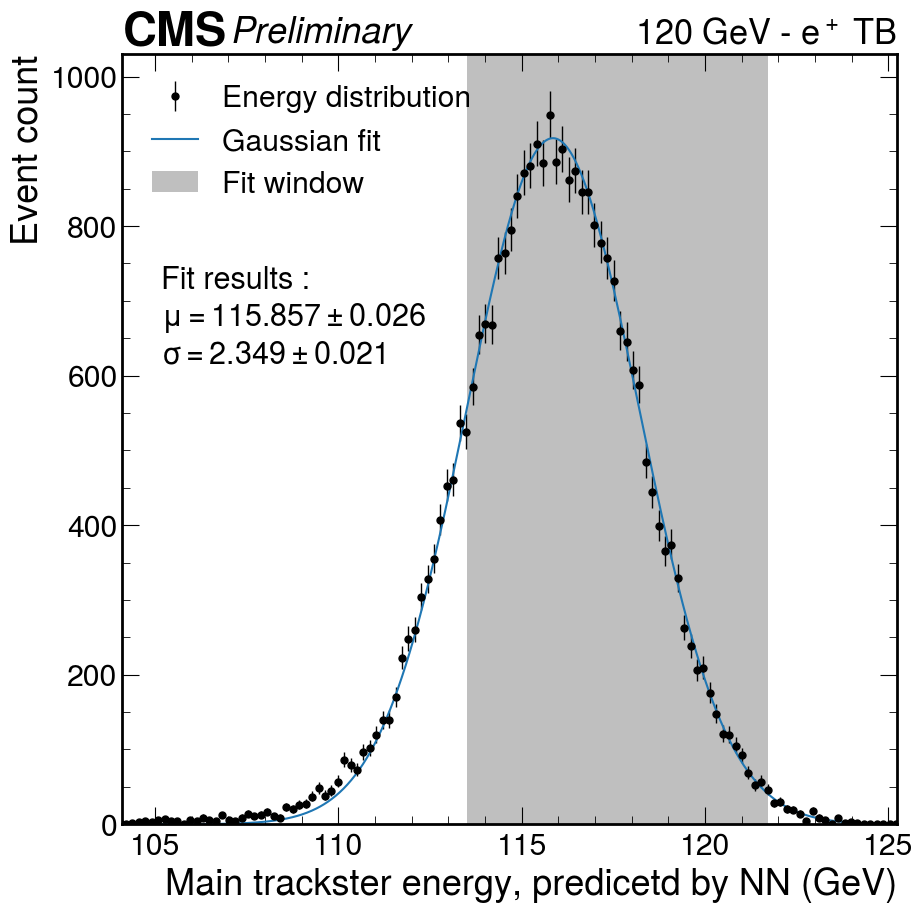

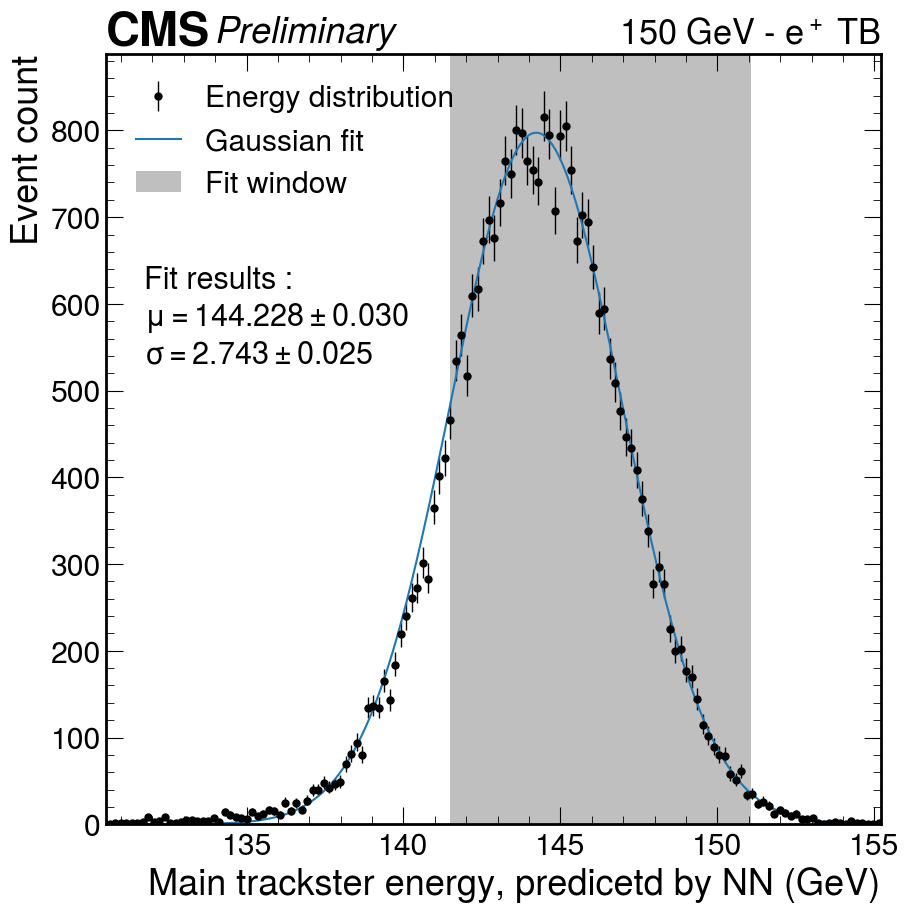

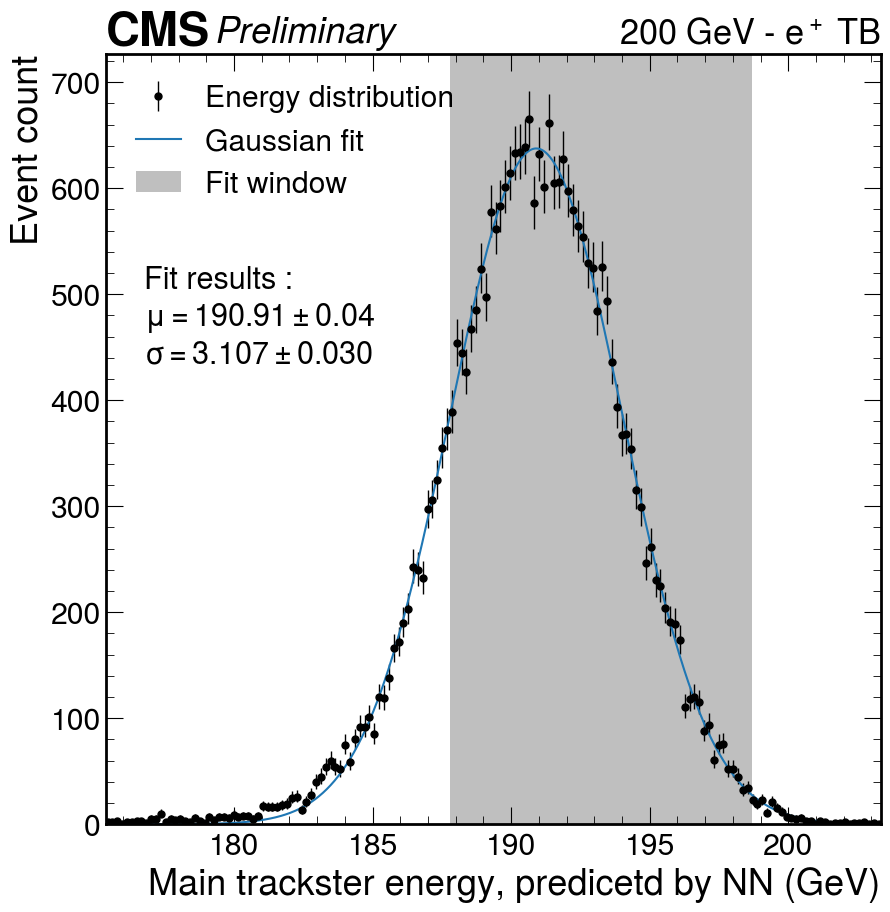

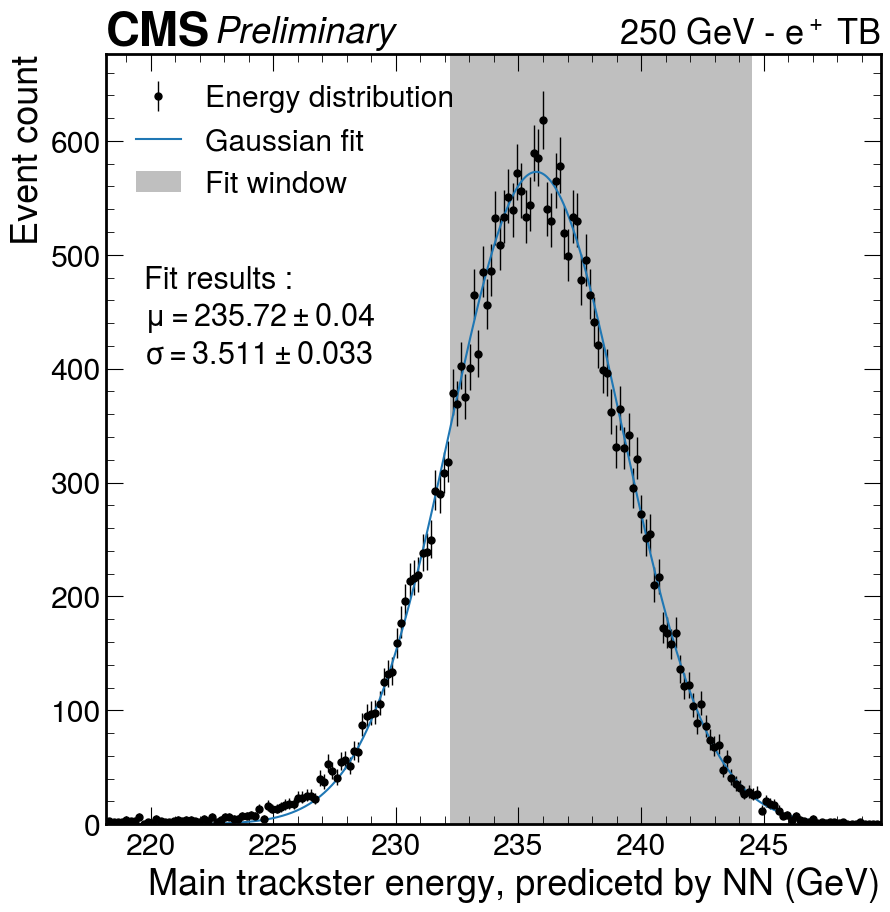

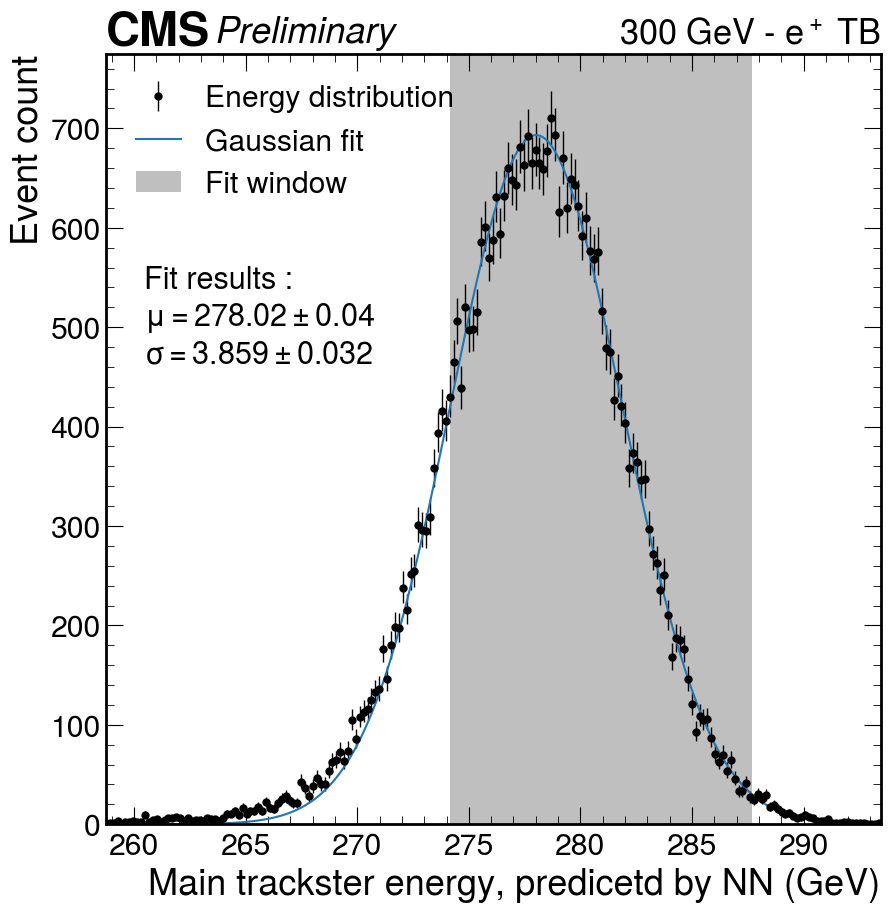

In [62]:
plotter.plotSigmaOverEFits()[50]